In [1]:
import pandas as pd

df = pd.read_csv('rented bike.csv')
df.head()

,Date,Rented Bike count,Hour,Temperature,Humidity,Windspeed,Visibility,Dew point temperature,Solar radiation,Rainfall,Snowfall,Seasons,Holiday,Functional Day,SO2,CO,O3,NO2,PM10,PM25
0,2017-12-12,127,1,-11.2,51,1.1,2000,-19.3,0.0,0.0,0.0,Winter,No Holiday,Yes,0.004167,0.432432,0.014486,0.015486,31.222222,17.04
1,2017-12-12,95,2,-11.5,50,0.7,2000,-19.8,0.0,0.0,0.0,Winter,No Holiday,Yes,0.004333,0.424324,0.014973,0.013865,32.000000,16.60
2,2017-12-12,54,3,-11.6,50,2.2,1995,-19.9,0.0,0.0,0.0,Winter,No Holiday,Yes,0.004361,0.413514,0.015324,0.013000,32.000000,16.92
3,2017-12-12,46,4,-11.6,47,2.1,1982,-20.6,0.0,0.0,0.0,Winter,No Holiday,Yes,0.004722,0.389189,0.016703,0.011432,33.108108,15.52
4,2017-12-12,65,5,-11.6,45,2.8,1951,-21.1,0.0,0.0,0.0,Winter,No Holiday,Yes,0.005056,0.408108,0.015514,0.013432,35.594595,17.64


타겟이 skewed 상태라 log transform 전후의 간단한 모델 성능을 비교한다.

In [2]:
# 자전거 대여 수에 날짜가 영향을 줄 수 없게 컬럼을 삭제

df.drop('Date',axis=1,inplace=True)

In [3]:
from sklearn.model_selection import train_test_split
target = 'Rented Bike count'
feature = df.drop(target,axis=1).columns

train, test = train_test_split(df,random_state=2,train_size=0.8)
train.shape,test.shape

((6513, 19), (1629, 19))

In [4]:
train, val = train_test_split(train,random_state=2,train_size=0.8)
train.shape,val.shape

((5210, 19), (1303, 19))

In [5]:
X_train = train[feature]
y_train = train[target]
X_val = val[feature]
y_val = val[target]
X_test = test[feature]
y_test = test[target]


In [6]:
import numpy as np

y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

In [7]:
pip install category_encoders

Note: you may need to restart the kernel to use updated packages.


In [8]:
from sklearn.linear_model import LinearRegression
from category_encoders import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
pipe1 = make_pipeline(
    OneHotEncoder(),
    StandardScaler(),
    LinearRegression()    
)
# not log transformation
pipe1.fit(X_train,y_train)
print(pipe1.score(X_val,y_val))


0.5601657848305468


C:\Users\parkj\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [9]:
pipe2 = make_pipeline(
    OneHotEncoder(),
    StandardScaler(),
    LinearRegression()    
)
# log transformation
pipe2.fit(X_train,y_train_log)
print(pipe2.score(X_val,y_val_log))


0.8199231878982064


C:\Users\parkj\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


# 성능차이가 심함
로그 변환을 하고 모델을 학습시키기로 결정!

data leakage를 방지하기 위해서 X와 y 를 분할 한 후에 표준화를 수행했다.
만들고자 하는 모델은 일기 예보를 통해 다음날 자전거 대여수를 예측해 수요에 따른 공급을 조절 할 수 있는 모델이다.
한계는 예보에 의존해야만 수요를 예측 할 수 있고, 자전거 대여에 미치는 여러가지 영향 중 날씨와 대기오염수치만을 특성으로 쓰기 때문에 다른 요인에 의해서 예측이 틀릴 수 있다. 가장 큰 문제점은 예보의 정확성에 따라서 예측의 성능이 크게 좌우 된다.

# 모델별 평가지표, 베이스라인과 비교

In [14]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

print('베이스라인 mae : ',mean_absolute_error(y_val_log,len(y_val)*[y_train_log.mean()]))
print('베이스라인 mse : ',mean_squared_error(y_val_log,len(y_val)*[y_train_log.mean()]))
print('베이스라인 r2 : ',r2_score(y_val_log,len(y_val)*[y_train_log.mean()]))


베이스라인 mae :  1.2060475388403624
베이스라인 mse :  2.775835088899767
베이스라인 r2 :  -0.00046111135638815526


In [19]:
#LinearRegression 평가지표 

linear_model = make_pipeline(
    OneHotEncoder(),
    StandardScaler(),
    LinearRegression()    
)
linear_model.fit(X_train,y_train_log)
print('훈련 평가지표')
print('linear_model mae : ',mean_absolute_error(y_train_log,linear_model.predict(X_train)))
print('linear_model mse : ',mean_squared_error(y_train_log,linear_model.predict(X_train)))
print('linear_model r2 : ',r2_score(y_train_log,linear_model.predict(X_train)))
print('검증 평가지표')
print('linear_model mae : ',mean_absolute_error(y_val_log,linear_model.predict(X_val)))
print('linear_model mse : ',mean_squared_error(y_val_log,linear_model.predict(X_val)))
print('linear_model r2 : ',r2_score(y_val_log,linear_model.predict(X_val)))

훈련 평가지표
linear_model mae :  0.5049892122682386
linear_model mse :  0.49083846156064403
linear_model r2 :  0.8065882796392836
검증 평가지표
linear_model mae :  0.5155142084827639
linear_model mse :  0.49963314721116187
linear_model r2 :  0.8199231878982064


C:\Users\parkj\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [20]:
#RidgeRegression 평가지표
from sklearn.linear_model import Ridge

ridge_model = make_pipeline(
    OneHotEncoder(),
    StandardScaler(),
    Ridge()    
)
ridge_model.fit(X_train,y_train_log)

print('훈련 평가지표')
print('ridge_model mae : ',mean_absolute_error(y_train_log,ridge_model.predict(X_train)))
print('ridge_model mse : ',mean_squared_error(y_train_log,ridge_model.predict(X_train)))
print('ridge_model r2 : ',r2_score(y_train_log,ridge_model.predict(X_train)))
print('검증 평가지표')
print('ridge_model mae : ',mean_absolute_error(y_val_log,ridge_model.predict(X_val)))
print('ridge_model mse : ',mean_squared_error(y_val_log,ridge_model.predict(X_val)))
print('ridge_model r2 : ',r2_score(y_val_log,ridge_model.predict(X_val)))

훈련 평가지표
ridge_model mae :  0.5050051670199232
ridge_model mse :  0.4908476759981824
ridge_model r2 :  0.8065846487497832
검증 평가지표
ridge_model mae :  0.515346339472879
ridge_model mse :  0.499394022858736
ridge_model r2 :  0.8200093726345896


C:\Users\parkj\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [21]:
from sklearn.ensemble import RandomForestRegressor

#RFRegression 평가지표 

rfreg_model = make_pipeline(
    OneHotEncoder(),
    StandardScaler(),
    RandomForestRegressor()    
)
rfreg_model.fit(X_train,y_train_log)

print('훈련 평가지표')
print('rfreg_model mae : ',mean_absolute_error(y_train_log,rfreg_model.predict(X_train)))
print('rfreg_model mse : ',mean_squared_error(y_train_log,rfreg_model.predict(X_train)))
print('rfreg_model r2 : ',r2_score(y_train_log,rfreg_model.predict(X_train)))
print('검증 평가지표')
print('rfreg_model mae : ',mean_absolute_error(y_val_log,rfreg_model.predict(X_val)))
print('rfreg_model mse : ',mean_squared_error(y_val_log,rfreg_model.predict(X_val)))
print('rfreg_model r2 : ',r2_score(y_val_log,rfreg_model.predict(X_val)))

C:\Users\parkj\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


훈련 평가지표
rfreg_model mae :  0.0950701767923763
rfreg_model mse :  0.022868963534179665
rfreg_model r2 :  0.9909886328672194
검증 평가지표
rfreg_model mae :  0.27196655521396257
rfreg_model mse :  0.1988752568248234
rfreg_model r2 :  0.9283217647691338


In [22]:
from sklearn.ensemble import AdaBoostRegressor

#AdaBoostRegression 평가지표 

adaboost_model = make_pipeline(
    OneHotEncoder(),
    StandardScaler(),
    AdaBoostRegressor()    
)
adaboost_model.fit(X_train,y_train_log)

print('훈련 평가지표')
print('adaboost_model mae : ',mean_absolute_error(y_train_log,adaboost_model.predict(X_train)))
print('adaboost_model mse : ',mean_squared_error(y_train_log,adaboost_model.predict(X_train)))
print('adaboost_model r2 : ',r2_score(y_train_log,adaboost_model.predict(X_train)))
print('검증 평가지표')
print('adaboost_model mae : ',mean_absolute_error(y_val_log,adaboost_model.predict(X_val)))
print('adaboost_model mse : ',mean_squared_error(y_val_log,adaboost_model.predict(X_val)))
print('adaboost_model r2 : ',r2_score(y_val_log,adaboost_model.predict(X_val)))

C:\Users\parkj\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


훈련 평가지표
adaboost_model mae :  0.5982266029467769
adaboost_model mse :  0.5283199569874615
adaboost_model r2 :  0.7918189388481331
검증 평가지표
adaboost_model mae :  0.60405897454374
adaboost_model mse :  0.5661883345393938
adaboost_model r2 :  0.7959354960691044


In [23]:
pip install xgboost

In [24]:
from xgboost import XGBRegressor

#XGBregression 평가지표 

xgboost_model = make_pipeline(
    OneHotEncoder(),
    StandardScaler(),
    XGBRegressor()    
)
xgboost_model.fit(X_train,y_train_log)

print('훈련 평가지표')
print('xgboost_model mae : ',mean_absolute_error(y_train_log,xgboost_model.predict(X_train)))
print('xgboost_model mse : ',mean_squared_error(y_train_log,xgboost_model.predict(X_train)))
print('xgboost_model r2 : ',r2_score(y_train_log,xgboost_model.predict(X_train)))
print('검증 평가지표')
print('xgboost_model mae : ',mean_absolute_error(y_val_log,xgboost_model.predict(X_val)))
print('xgboost_model mse : ',mean_squared_error(y_val_log,xgboost_model.predict(X_val)))
print('xgboost_model r2 : ',r2_score(y_val_log,xgboost_model.predict(X_val)))

C:\Users\parkj\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


훈련 평가지표
xgboost_model mae :  0.09811799775098158
xgboost_model mse :  0.01932250938013103
xgboost_model r2 :  0.9923860901832864
검증 평가지표
xgboost_model mae :  0.2742966228792131
xgboost_model mse :  0.19393628439957702
xgboost_model r2 :  0.9301018596534733


베이스라인 평가지표가 너무 안 좋아서 비교하기 뭐하지만, 성능이 좋은 모델들은 
randomforest , xgboost정도이다.

In [35]:

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint

rfreg_model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    StandardScaler(),
    RandomForestRegressor()    
)



dists = {
    'randomforestregressor__n_estimators': randint(1,1000), 
    'randomforestregressor__max_depth': randint(1,20),
    'randomforestregressor__min_samples_split' : randint(1,100),
    'randomforestregressor__min_samples_leaf' : randint(1,20),
    'randomforestregressor__max_features' : ['sqrt','log']
}

clf = RandomizedSearchCV(
    rfreg_model, 
    param_distributions=dists, 
    n_iter=500, 
    cv=3,
    scoring='r2',
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train, y_train_log);
print('최적 하이퍼파라미터: ', clf.best_params_)


Fitting 3 folds for each of 500 candidates, totalling 1500 fits


C:\Users\parkj\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.8956961         nan        nan 0.88077463        nan 0.86505724
        nan 0.87291228 0.884491          nan 0.87442108        nan
        nan        nan        nan 0.56782946 0.86025554        nan
        nan        nan        nan 0.82385988 0.86747992 0.87240277
        nan 0.881164   0.81521708        nan        nan        nan
 0.86722185 0.77131871 0.82021528 0.86563641 0.86925918 0.87041541
        nan        nan        nan 0.81815953        nan        nan
        nan 0.82482485 0.77754462        nan        nan        nan
 0.83817302        nan 0.88998259 0.87540395        nan        nan
 0.85037044        nan 0.86473951 0.81989018        nan        nan
        nan 0.69879713        nan        nan        nan 0.56248351
 0.89632563        nan 0.86396648 0.56404044        nan 0.35707734
 0.8805706         nan        nan 0.85958434        n

최적 하이퍼파라미터:  {'randomforestregressor__max_depth': 19, 'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__min_samples_split': 7, 'randomforestregressor__n_estimators': 290}


In [36]:
rfreg_model_best = clf.best_estimator_

print('훈련 평가지표')
print('rfreg_model_best mae : ',mean_absolute_error(y_train_log,rfreg_model_best.predict(X_train)))
print('rfreg_model_best mse : ',mean_squared_error(y_train_log,rfreg_model_best.predict(X_train)))
print('rfreg_model_best r2 : ',r2_score(y_train_log,rfreg_model_best.predict(X_train)))
print('검증 평가지표')
print('rfreg_model_best mae : ',mean_absolute_error(y_val_log,rfreg_model_best.predict(X_val)))
print('rfreg_model_best mse : ',mean_squared_error(y_val_log,rfreg_model_best.predict(X_val)))
print('rfreg_model_best r2 : ',r2_score(y_val_log,rfreg_model_best.predict(X_val)))

훈련 평가지표
rfreg_model_best mae :  0.16426562125129007
rfreg_model_best mse :  0.058331250747428426
rfreg_model_best r2 :  0.9770149480096141
검증 평가지표
rfreg_model_best mae :  0.3085733098679705
rfreg_model_best mse :  0.21429849365603776
rfreg_model_best r2 :  0.9227629515951907


In [37]:
param = {
    'randomforestregressor__n_estimators': [250,260,270,280,290,300,310,320,330], 
    'randomforestregressor__max_depth': [16,17,18,19,20,21,22],
    'randomforestregressor__min_samples_split' : [5,6,7,8,9,10],
    'randomforestregressor__min_samples_leaf' : [1,2,3,4,5,6,7,8,9,10],
    'randomforestregressor__max_features' : ['sqrt','log']
}

gridcv = GridSearchCV(
    rfreg_model, 
    param_grid = param, 
    cv=3,
    n_jobs=-1
)

gridcv.fit(X_train, y_train_log);

C:\Users\parkj\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.92245243 0.92241764 0.92359958 ...        nan        nan        nan]
  warnings.warn(
C:\Users\parkj\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [38]:
print('최적 하이퍼파라미터: ', gridcv.best_params_)

최적 하이퍼파라미터:  {'randomforestregressor__max_depth': 19, 'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__min_samples_split': 5, 'randomforestregressor__n_estimators': 250}


In [45]:
rfreg_model_bestcv = gridcv.best_estimator_
y_test_log = np.log1p(y_test)
print('훈련 평가지표')
print('rfreg_model_bestcv mae : ',mean_absolute_error(y_train_log,rfreg_model_bestcv.predict(X_train)))
print('rfreg_model_bestcv mse : ',mean_squared_error(y_train_log,rfreg_model_bestcv.predict(X_train)))
print('rfreg_model_bestcv r2 : ',r2_score(y_train_log,rfreg_model_bestcv.predict(X_train)))
print('검증 평가지표')
print('rfreg_model_bestcv mae : ',mean_absolute_error(y_val_log,rfreg_model_bestcv.predict(X_val)))
print('rfreg_model_bestcv mse : ',mean_squared_error(y_val_log,rfreg_model_bestcv.predict(X_val)))
print('rfreg_model_bestcv r2 : ',r2_score(y_val_log,rfreg_model_bestcv.predict(X_val)))
print('테스트 평가지표')
print('rfreg_model_bestcv mae : ',mean_absolute_error(y_test_log,rfreg_model_bestcv.predict(X_test)))
print('rfreg_model_bestcv mse : ',mean_squared_error(y_test_log,rfreg_model_bestcv.predict(X_test)))
print('rfreg_model_bestcv r2 : ',r2_score(y_test_log,rfreg_model_bestcv.predict(X_test)))


훈련 평가지표
rfreg_model_bestcv mae :  0.14643429044503797
rfreg_model_bestcv mse :  0.04635937761239151
rfreg_model_bestcv r2 :  0.9817323871679585
검증 평가지표
rfreg_model_bestcv mae :  0.3047683574032051
rfreg_model_bestcv mse :  0.21259285808382392
rfreg_model_bestcv r2 :  0.9233776934676348
테스트 평가지표
rfreg_model_bestcv mae :  0.2932630406728174
rfreg_model_bestcv mse :  0.18519369271798466
rfreg_model_bestcv r2 :  0.9259985458762635


In [55]:
xgboost_model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    StandardScaler(),
    XGBRegressor()    
)
param_tuning = {
        'xgbregressor__learning_rate': [0.01, 0.1],
        'xgbregressor__max_depth': [3, 5, 7, 10],
        'xgbregressor__min_child_weight': [1, 3, 5],
        'xgbregressor__subsample': [0.5, 0.7],
        'xgbregressor__colsample_bytree': [0.5, 0.7],
        'xgbregressor__n_estimators' : [100, 200, 500],
        'xgbregressor__objective': ['reg:squarederror']
    }
gsearch = GridSearchCV(estimator = xgboost_model,
                           param_grid = param_tuning,
                           scoring='r2',
                           cv = 3,
                           n_jobs = -1,
                           verbose = 1)

gsearch.fit(X_train,y_train_log)
print('최적 하이퍼파라미터: ', gsearch.best_params_)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


C:\Users\parkj\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


최적 하이퍼파라미터:  {'xgbregressor__colsample_bytree': 0.7, 'xgbregressor__learning_rate': 0.1, 'xgbregressor__max_depth': 10, 'xgbregressor__min_child_weight': 5, 'xgbregressor__n_estimators': 500, 'xgbregressor__objective': 'reg:squarederror', 'xgbregressor__subsample': 0.7}


In [56]:
xgboost_best = gsearch.best_estimator_
print('훈련 평가지표')
print('xgboost_best mae : ',mean_absolute_error(y_train_log,xgboost_best.predict(X_train)))
print('xgboost_best mse : ',mean_squared_error(y_train_log,xgboost_best.predict(X_train)))
print('xgboost_best r2 : ',r2_score(y_train_log,xgboost_best.predict(X_train)))
print('검증 평가지표')
print('xgboost_best mae : ',mean_absolute_error(y_val_log,xgboost_best.predict(X_val)))
print('xgboost_best mse : ',mean_squared_error(y_val_log,xgboost_best.predict(X_val)))
print('xgboost_best r2 : ',r2_score(y_val_log,xgboost_best.predict(X_val)))
print('테스트 평가지표')
print('xgboost_best mae : ',mean_absolute_error(y_test_log,xgboost_best.predict(X_test)))
print('xgboost_best mse : ',mean_squared_error(y_test_log,xgboost_best.predict(X_test)))
print('xgboost_best r2 : ',r2_score(y_test_log,xgboost_best.predict(X_test)))

훈련 평가지표
xgboost_best mae :  0.004822082247968655
xgboost_best mse :  4.9834041155244066e-05
xgboost_best r2 :  0.9999803632184778
검증 평가지표
xgboost_best mae :  0.24930658954762197
xgboost_best mse :  0.16786196942416953
xgboost_best r2 :  0.9394995138017578
테스트 평가지표
xgboost_best mae :  0.2533084096419473
xgboost_best mse :  0.15562958751823203
xgboost_best r2 :  0.9378120517389086


In [49]:
pip install eli5

Note: you may need to restart the kernel to use updated packages.


In [50]:
import eli5
from eli5.sklearn import PermutationImportance


permuter = PermutationImportance(
    rfreg_model_bestcv.named_steps['randomforestregressor'], # model
    scoring='r2',
    n_iter=5,
    random_state=2
)

# permuter 계산은 preprocessing 된 X_val을 사용합니다.
X_val_transformed = rfreg_model_bestcv.named_steps['standardscaler'].transform(rfreg_model_bestcv.named_steps['onehotencoder'].transform(X_val))

# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업입니다
permuter.fit(X_val_transformed, y_val_log);

In [53]:
feature_names =rfreg_model_bestcv.named_steps['onehotencoder'].transform(X_val).columns.tolist()
eli5.show_weights(
    permuter, 
    top=None,
    feature_names=feature_names
)

Weight,Feature
0.2572 ± 0.0252,Functional Day_Yes
0.2295 ± 0.0102,Functional Day_No
0.1262 ± 0.0034,Hour
0.1104 ± 0.0091,Temperature
0.0659 ± 0.0077,Humidity
0.0505 ± 0.0065,Seasons_Winter
0.0440 ± 0.0050,Rainfall
0.0204 ± 0.0010,Solar radiation
0.0135 ± 0.0009,Dew point temperature
0.0101 ± 0.0013,Visibility


randomforest의 순열중요도이다.

In [57]:

permuter = PermutationImportance(
    xgboost_best.named_steps['xgbregressor'], # model
    scoring='r2',
    n_iter=5,
    random_state=2
)

# permuter 계산은 preprocessing 된 X_val을 사용합니다.
X_val_transformed = xgboost_best.named_steps['standardscaler'].transform(xgboost_best.named_steps['onehotencoder'].transform(X_val))

# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업입니다
permuter.fit(X_val_transformed, y_val_log);
feature_names =xgboost_best.named_steps['onehotencoder'].transform(X_val).columns.tolist()
eli5.show_weights(
    permuter, 
    top=None,
    feature_names=feature_names
)

Weight,Feature
0.8932 ± 0.0782,Functional Day_Yes
0.1810 ± 0.0191,Temperature
0.1791 ± 0.0073,Hour
0.0754 ± 0.0114,Humidity
0.0574 ± 0.0036,Rainfall
0.0307 ± 0.0020,Dew point temperature
0.0236 ± 0.0041,Seasons_Winter
0.0160 ± 0.0022,Solar radiation
0.0120 ± 0.0020,Seasons_Autumn
0.0076 ± 0.0024,PM10


하이퍼 파라미터를 튜닝하지 않고 기본 모델에서 가장 성능이 좋은 두가지 모델을 선정했고, 하이퍼파라미터 튜닝을 한 후에 모델을 일반화 시켰다.모델을 학습한 후에 베이스라인보다 성능이 월등하게 상승했다.
모델 성능 개선을 위해서 randomizesearchcv를 이용해 대략적인 최적 성능을 찾고 그 후 gridsearchcv로 그 주변 하이퍼 파라미터를 모두 테스트 해서 모델의 성능을 개선했다.최종 모델은 일반화도 어느정도 됐고, 성능도 좋은 xgbregressor모델로 선정했고, 하이퍼파라미터는 다음과 같다.   
colsample_bytree : 0.7   
learning_rate : 0.1   
max_depth : 10   
min_child_weight : 5   
n_estimators : 500   
objective : reg:squarederror   
subsample : 0.7   


5) 머신러닝 모델 해석
프로젝트에서 가장 중요하다고 볼 수 있는 부분 입니다. 우리는 SHAP, PDP 등을 통해서 모델이 관측치를 어떤 특성을 활용했거나, 어떤 특성이 타겟에 영향을 끼쳤는지 등을 해석하는 방법에 대해서 배웠습니다.
여러분의 프로젝트에도 이러한 해석 방법을 활용해 머신러닝 모델을 비전문가라도 조금 더 쉽게 이해하고 접근할 수 있도록 해주셔야 합니다.

PDP, SHAP을 활용하여 최종 모델을 설명합니다
시각화는 "설명"이 제일 중요합니다.
태스크를 수행한 후, 다음 질문에 대답할 수 있어야 합니다.
모델이 관측치를 예측하기 위해서 어떤 특성을 활용했나요?
어떤 특성이 있다면 모델의 예측에 도움이 될까요? 해당 특성은 어떻게 구할 수 있을까요?


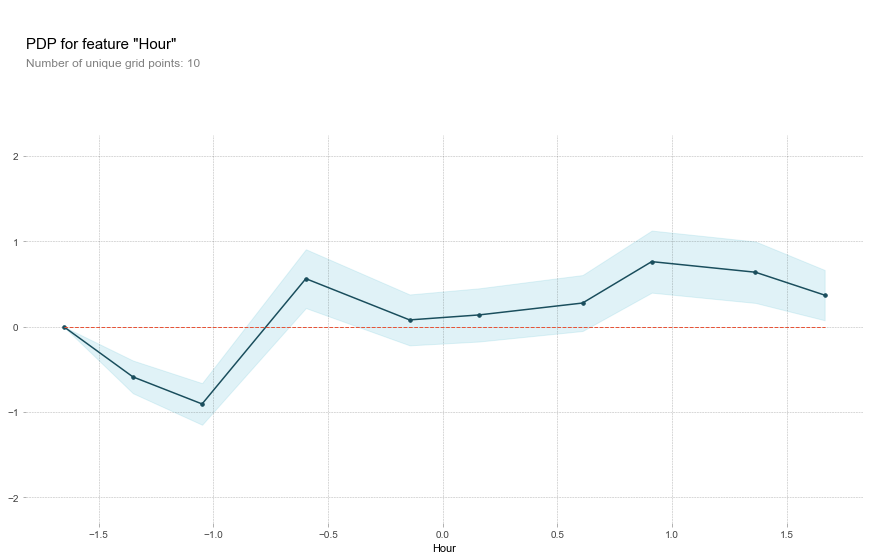

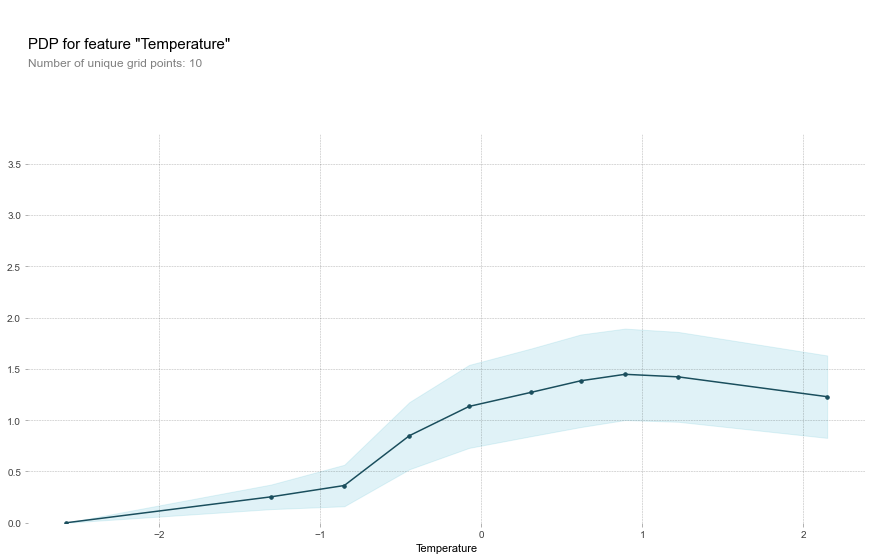

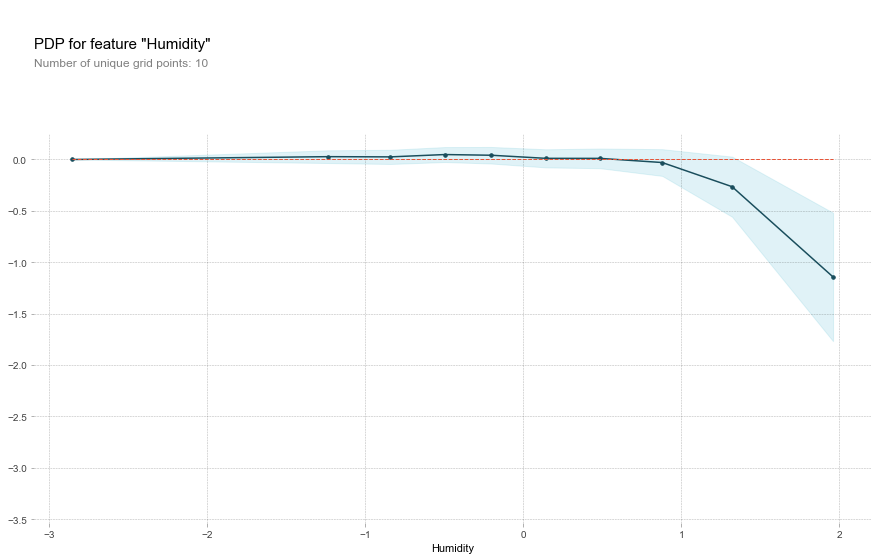

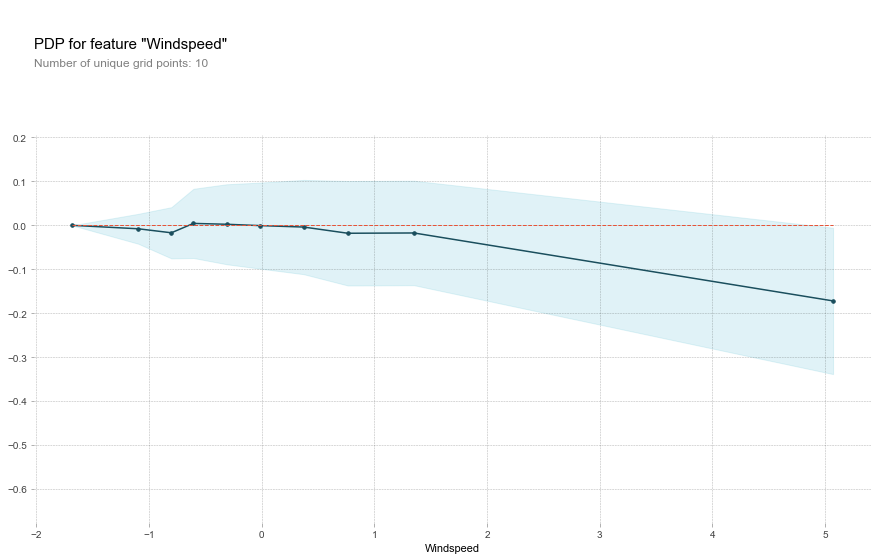

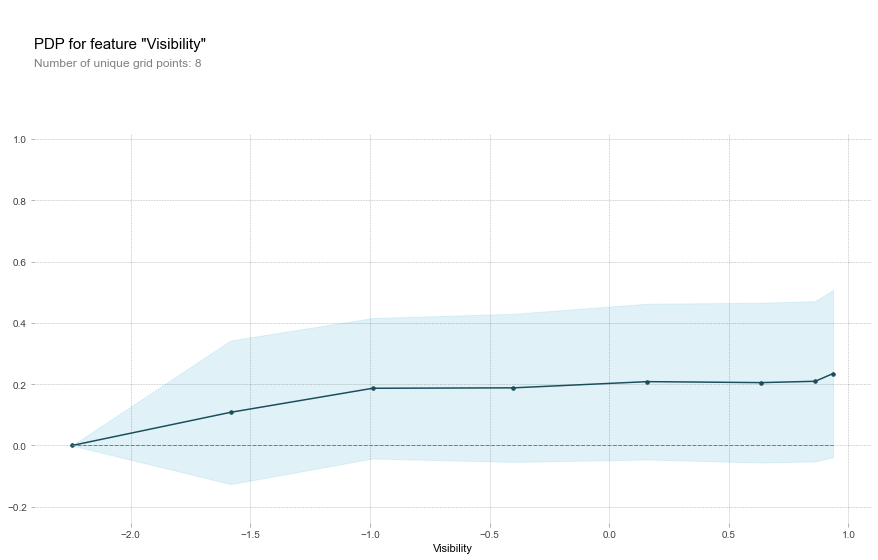

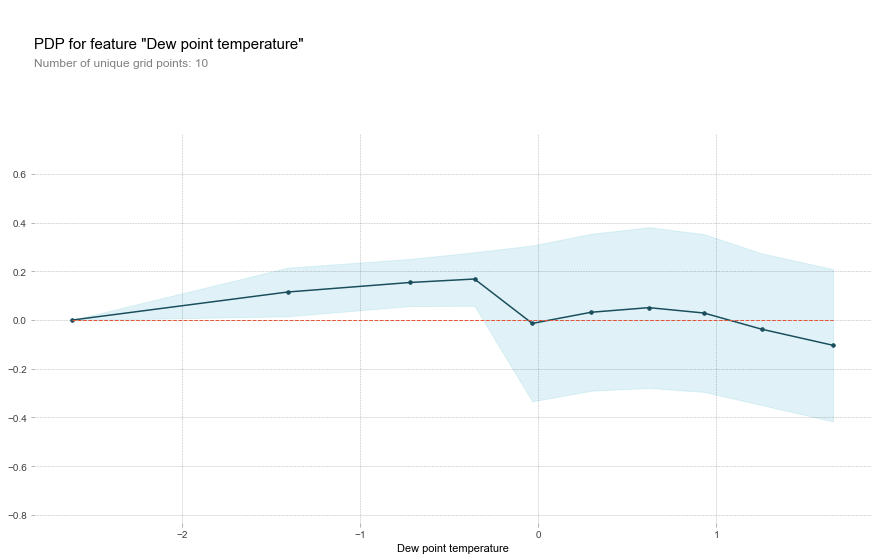

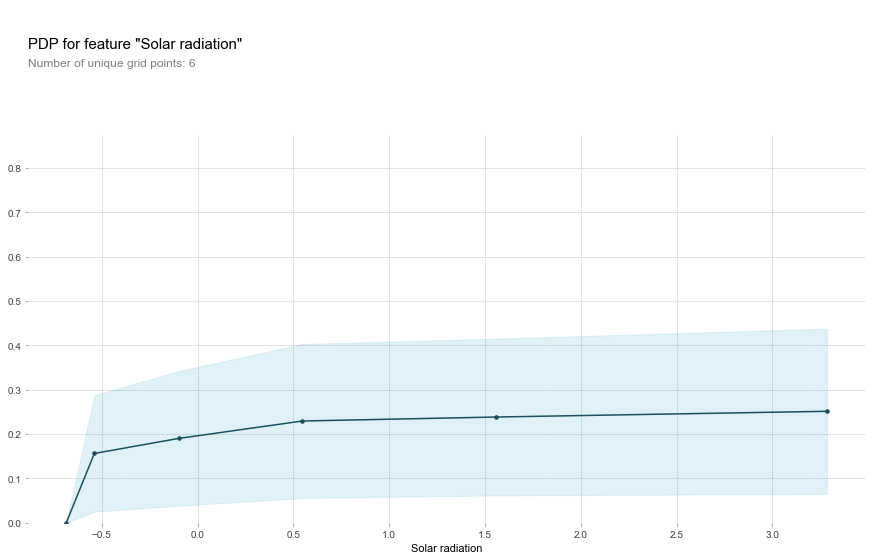

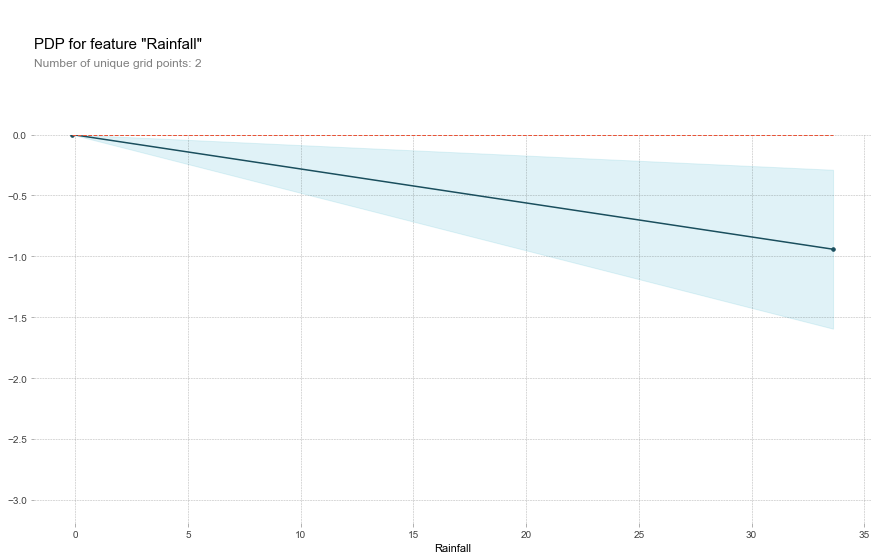

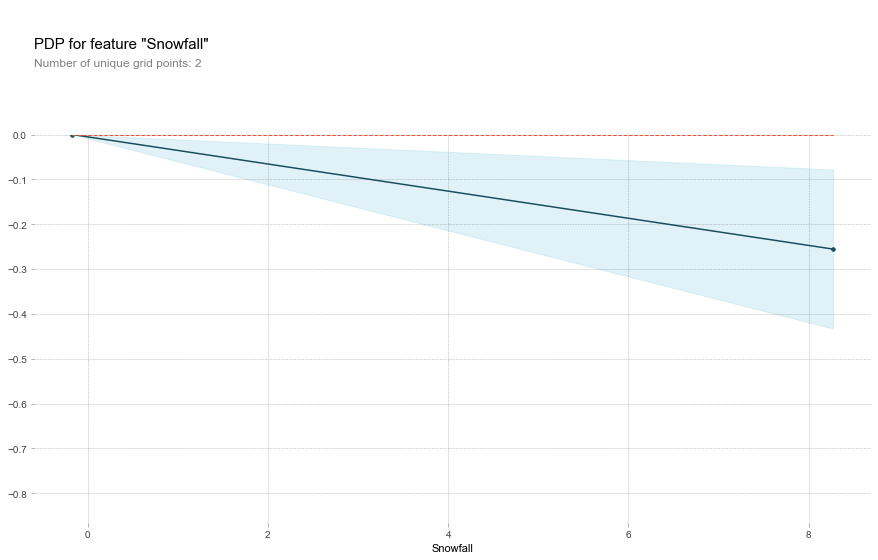

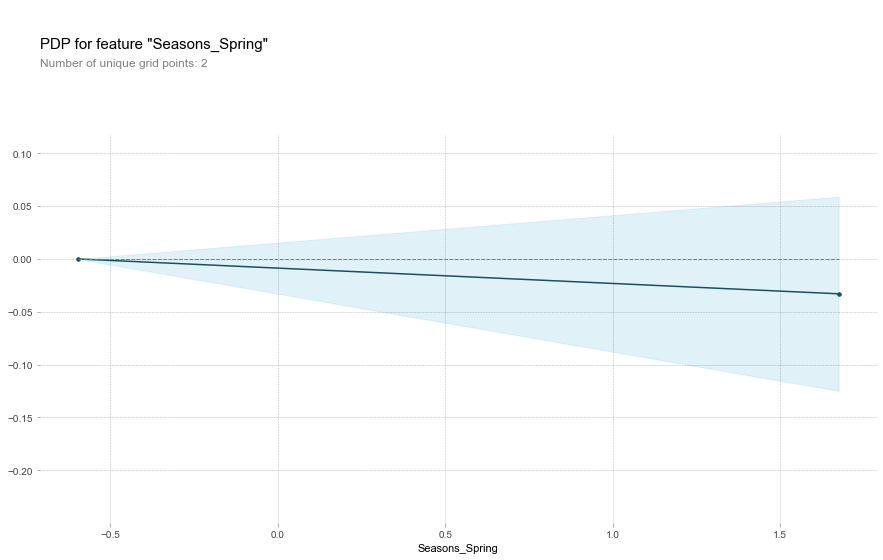

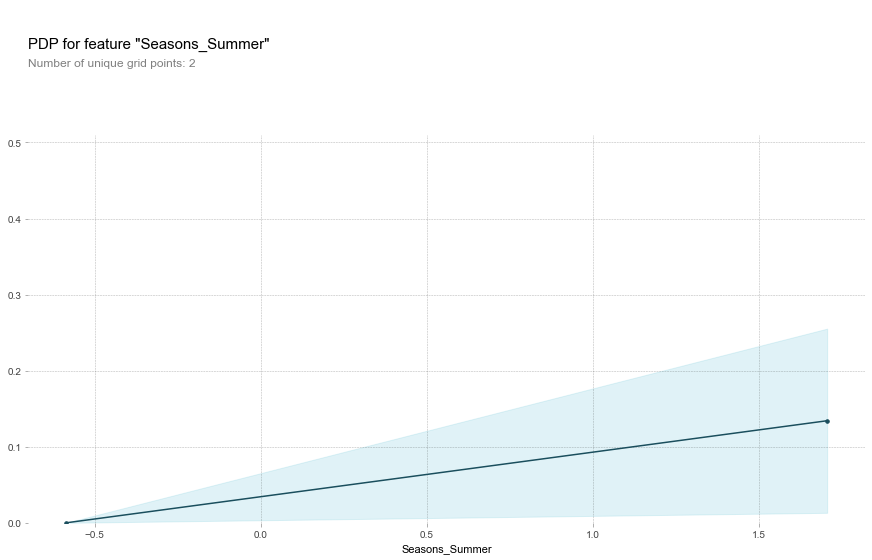

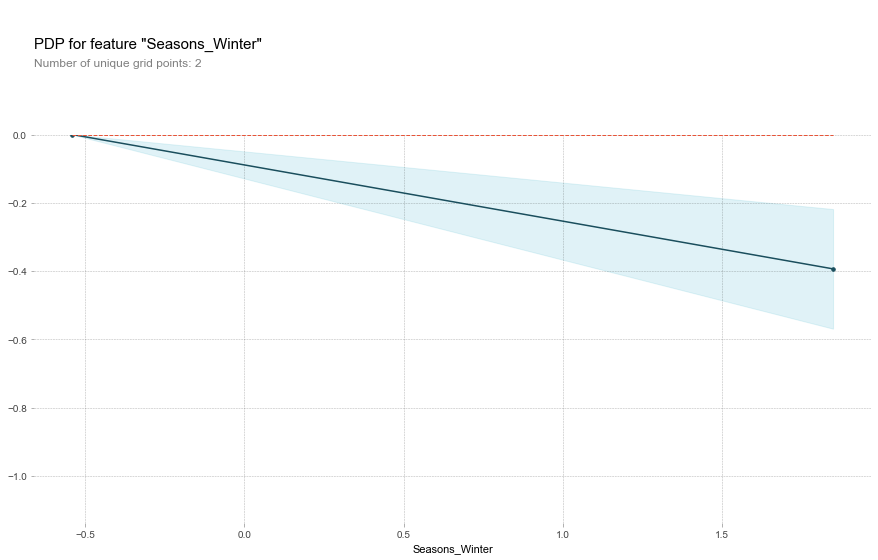

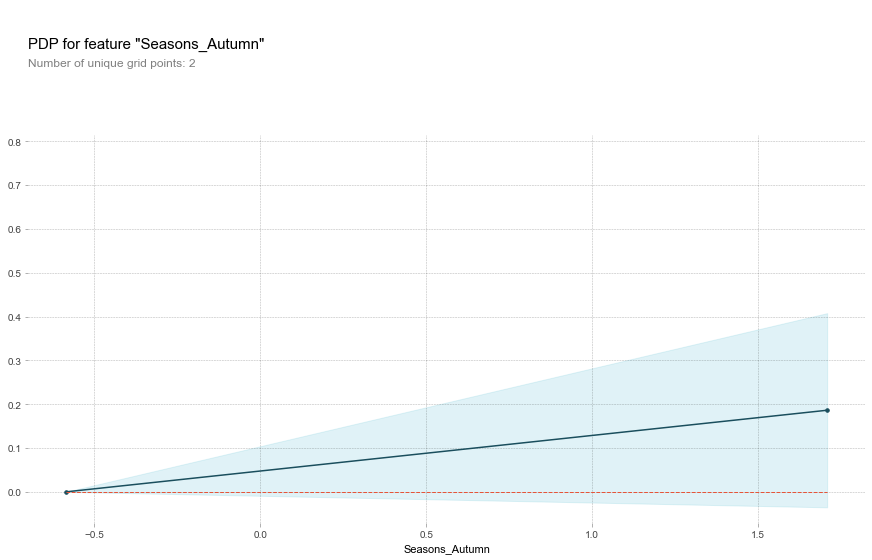

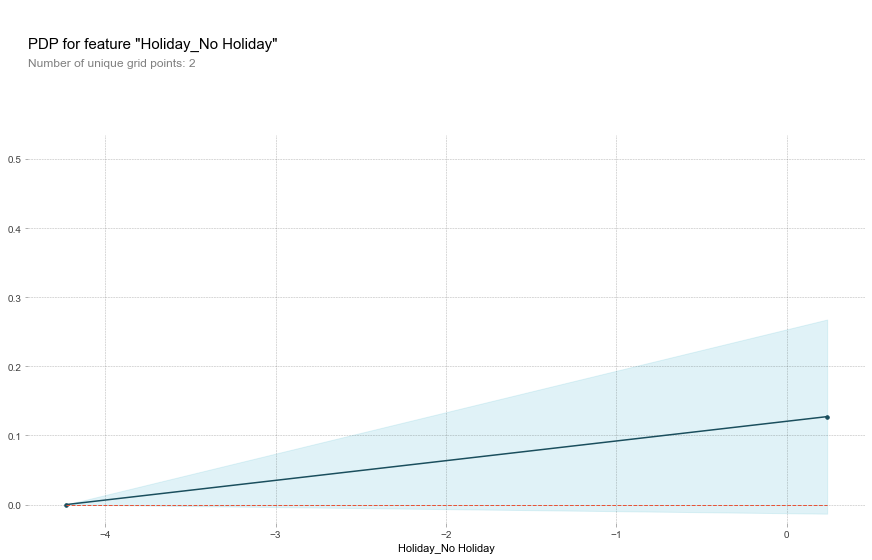

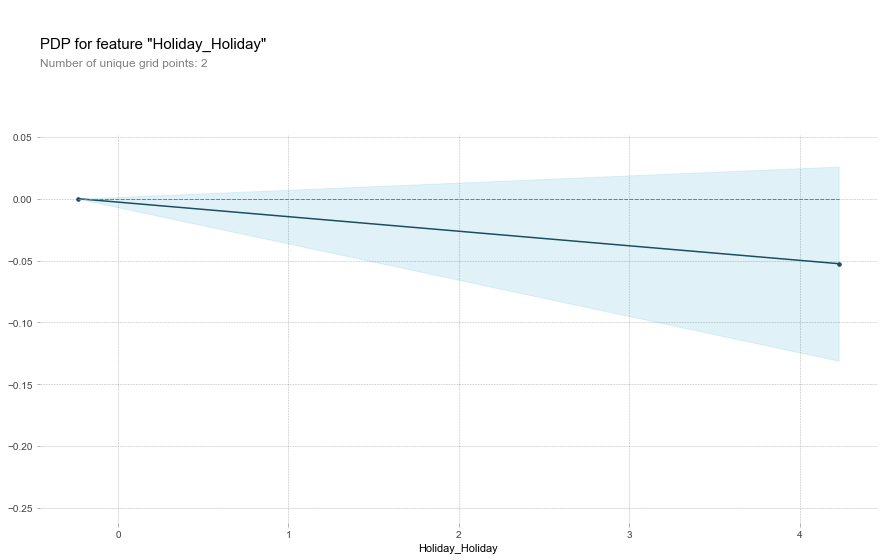

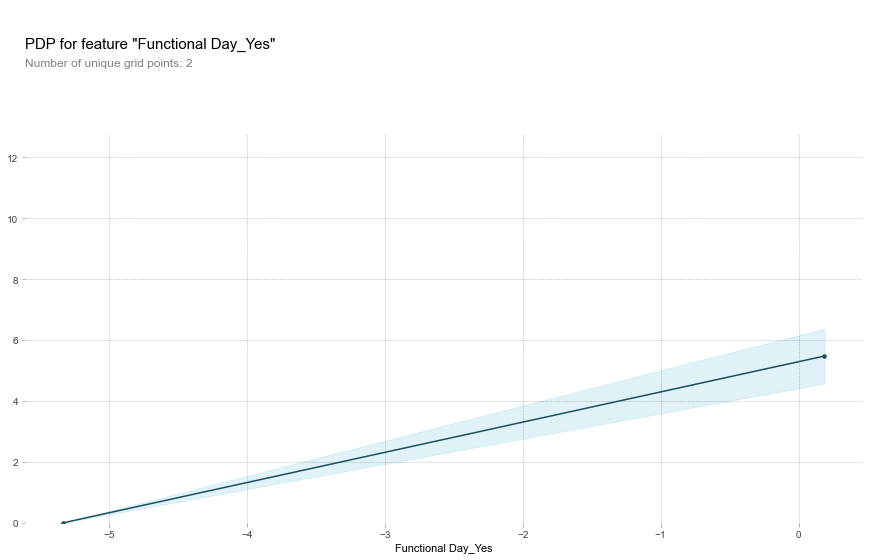

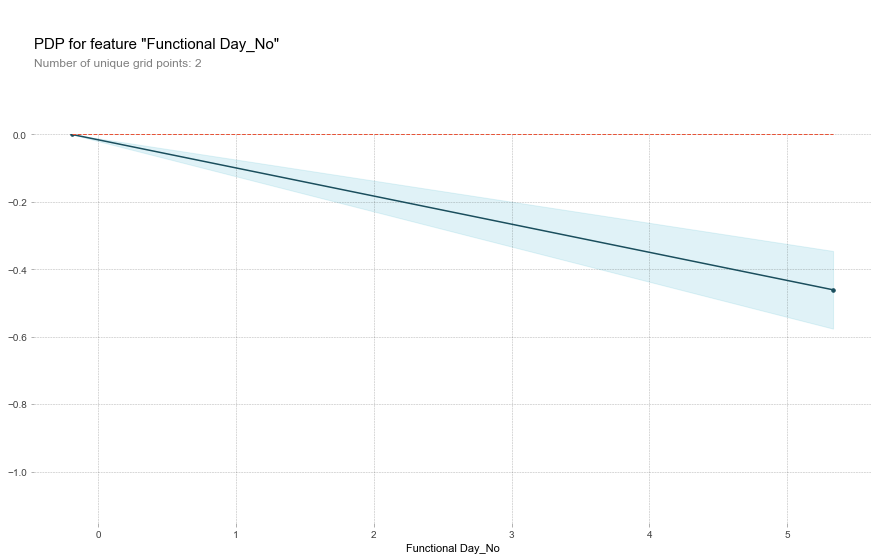

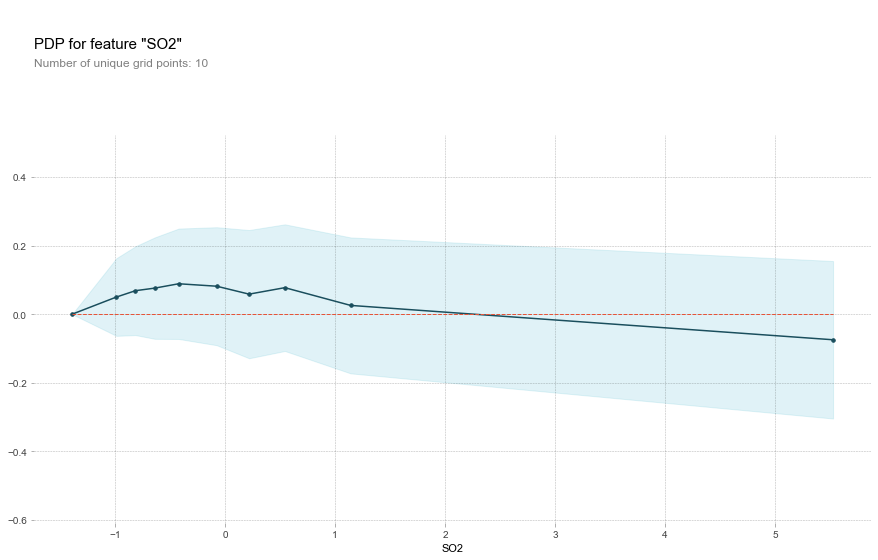

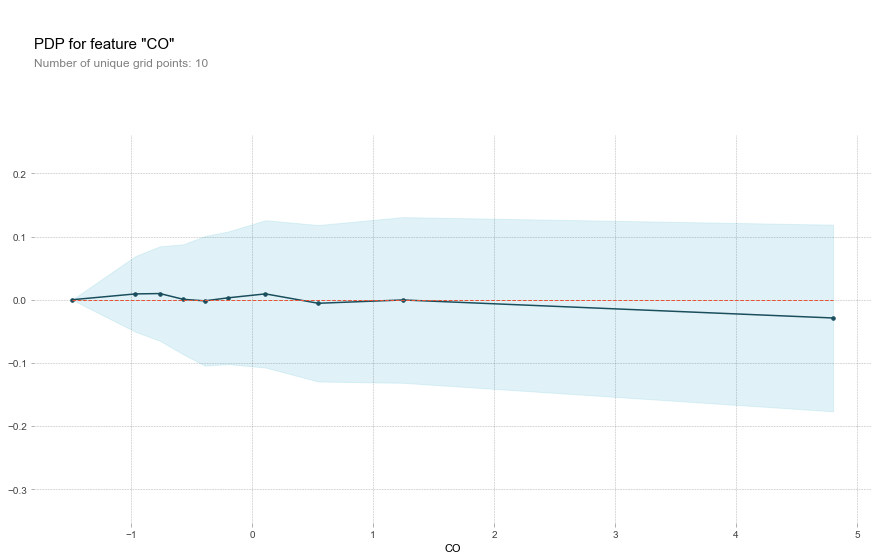

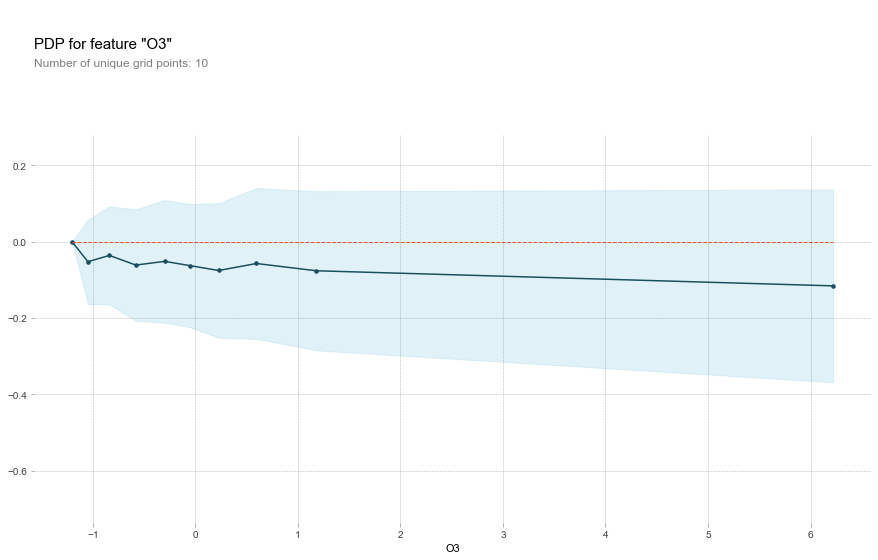

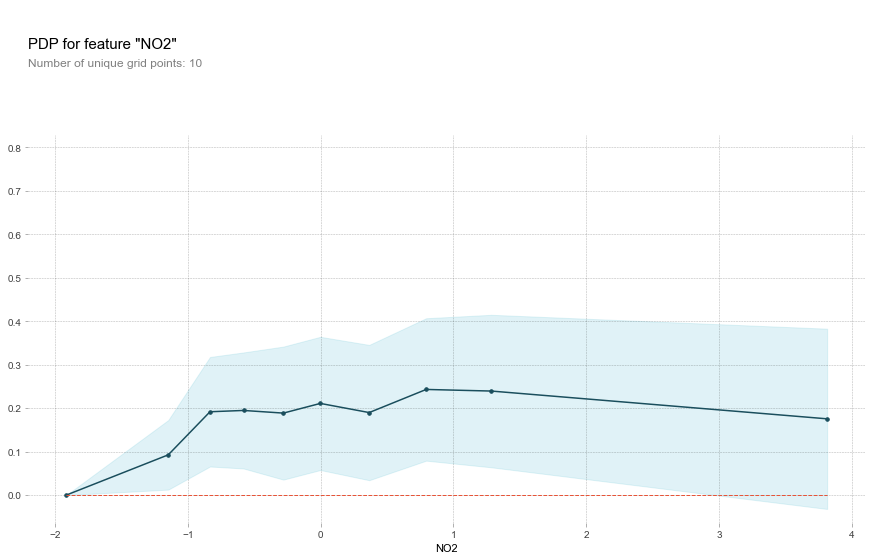

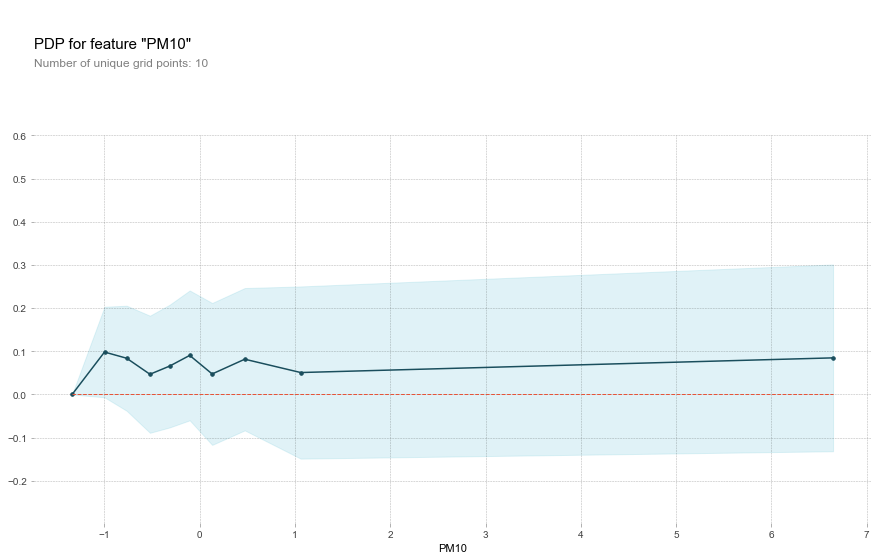

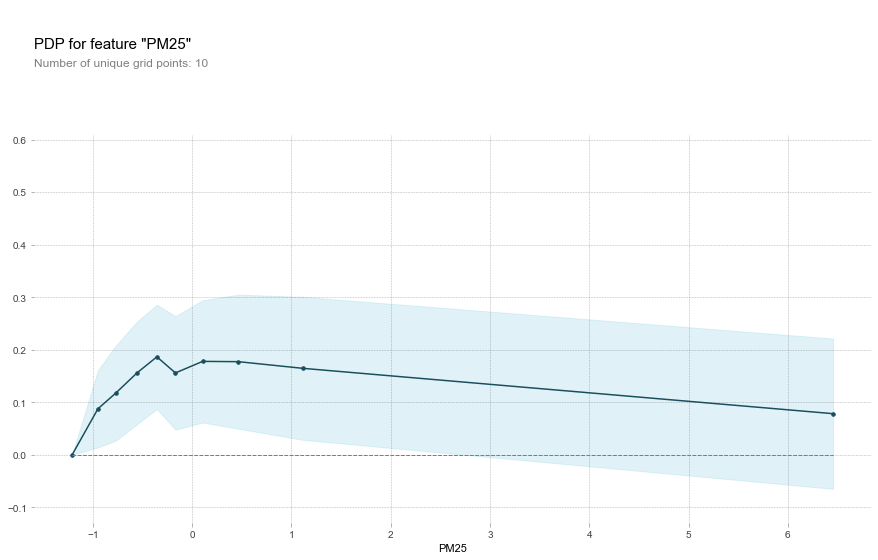

In [128]:
import shap
from pdpbox.pdp import pdp_isolate, pdp_plot

X_test_encoded = pd.DataFrame(xgboost_best.named_steps['standardscaler'].transform(xgboost_best.named_steps['onehotencoder'].transform(X_test)))
X_test_encoded.columns = xgboost_best.named_steps['onehotencoder'].transform(X_test).columns.to_list()
X_test_encoded
for i in X_test_encoded.columns.to_list() :
    isolated = pdp_isolate(
        model=xgboost_best.named_steps['xgbregressor'], 
        dataset=X_test_encoded,
        model_features=X_test_encoded.columns, 
        feature=i,
        grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
    )
    pdp_plot(isolated, feature_name=i);

In [137]:
X_test.iloc[[0]]

,Hour,Temperature,Humidity,Windspeed,Visibility,Dew point temperature,Solar radiation,Rainfall,Snowfall,Seasons,Holiday,Functional Day,SO2,CO,O3,NO2,PM10,PM25
3944,12,28.2,34,2.6,1867,10.8,3.26,0.0,0.0,Summer,No Holiday,Yes,0.006895,0.67027,0.0155,0.032763,53.552632,29.0


In [136]:
xgboost_best.named_steps['onehotencoder'].transform(X_test.iloc[[0]])

,Hour,Temperature,Humidity,Windspeed,Visibility,Dew point temperature,Solar radiation,Rainfall,Snowfall,Seasons_Spring,...,Holiday_No Holiday,Holiday_Holiday,Functional Day_Yes,Functional Day_No,SO2,CO,O3,NO2,PM10,PM25
3944,12,28.2,34,2.6,1867,10.8,3.26,0.0,0.0,0,...,1,0,1,0,0.006895,0.67027,0.0155,0.032763,53.552632,29.0


In [139]:
X_test_encoded.iloc[[0]]

,Hour,Temperature,Humidity,Windspeed,Visibility,Dew point temperature,Solar radiation,Rainfall,Snowfall,Seasons_Spring,...,Holiday_No Holiday,Holiday_Holiday,Functional Day_Yes,Functional Day_No,SO2,CO,O3,NO2,PM10,PM25
0,0.006742,1.264222,-1.184703,0.862371,0.716202,0.498863,2.992126,-0.135445,-0.173467,-0.597007,...,0.236513,-0.236513,0.187531,-0.187531,1.999348,0.639168,-0.35406,0.011889,0.373073,0.248279


In [130]:
explainer = shap.TreeExplainer(xgboost_best.named_steps['xgbregressor'])
shap_values = explainer.shap_values(X_test_encoded.iloc[[0]])

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=X_test_encoded.iloc[[0]]
)

기능 비기능일에 따라 자전거 대여